In [2]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [3]:
a = np.array([0,1,2])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1


In [4]:
from tensorflow.keras import layers

In [5]:
import pettingzoo
from pettingzoo.mpe import simple_spread_v1

In [6]:
env =simple_spread_v1.parallel_env(max_frames=100)


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [17]:
num_states = env.observation_spaces['agent_0'].shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_spaces['agent_0'].shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_spaces['agent_0'].high[0]
lower_bound = env.action_spaces['agent_0'].low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  18
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [18]:
num_states=21

In [19]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [20]:
std_dev = 0.998
ou_noise = OUActionNoise(mean=np.zeros(num_actions), std_deviation=float(std_dev) * np.ones(num_actions))

In [21]:
class Agent:
    def __init__(self, buffer_capacity=5, batch_size=3):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0
        self.last_states={'agent_0':0,'agent_1':0,'agent_2':0}
        
        self.next_states={'agent_0':0,'agent_1':0,'agent_2':0}
        
        self.state_buffer = np.zeros((self.buffer_capacity, 21))
        self.action_buffer = np.zeros((self.buffer_capacity, 2))
        self.next_state_buffer=np.zeros((self.buffer_capacity,21))
        self.reward_buffer=np.zeros((self.buffer_capacity,1))
        
        self.actor=get_actor()
        self.target_actor=get_actor()
        
        self.critic=get_critic()
        self.target_critic = get_critic()
        
        self.target_critic.set_weights(self.critic.get_weights())
        self.target_actor.set_weights(self.actor.get_weights())
        
        self.critic_lr = 0.0003
        self.actor_lr = 0.0003
        self.gamma=0.99
        self.tau=0.05
        self.epsilon=1
        self.episode_steps=0
        self.sum_rewards = []
        self.upper_bound=1
        self.lower_bound=-1
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)
    
    
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity   
        for agent in env.agents:
            self.state_buffer[index]=obs_tuple[0][agent]
            self.action_buffer[index]=obs_tuple[1][agent]
            self.reward_buffer[index]=obs_tuple[2][agent]
            self.next_state_buffer[index]=obs_tuple[3][agent]
            self.buffer_counter += 1
            index = self.buffer_counter % self.buffer_capacity        
        
        

    def learn(self):

        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batches=tf.convert_to_tensor(self.state_buffer[batch_indices],dtype=tf.float32)
     
        action_batches=tf.convert_to_tensor(self.action_buffer[batch_indices],dtype=tf.float32)
        next_state_batches=tf.convert_to_tensor(self.next_state_buffer[batch_indices],dtype=tf.float32)
        
        reward_batches=tf.convert_to_tensor(self.reward_buffer[batch_indices],dtype=tf.float32)
        self.update(state_batches,action_batches,next_state_batches,reward_batches)
    
    
    def update(self,state_batch,action_batch,next_state_batch,reward_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
          
            y = reward_batch + self.gamma * self.target_critic([next_state_batch, target_actions], training=True)
           
            critic_value = self.critic([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor(state_batch, training=True)
            critic_value = self.critic([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )

                                    
                                    
    def policy(self,state,noise_object):
        state = tf.convert_to_tensor(state)
        
        sampled_actions = tf.squeeze(self.actor(state))
       
        noise = noise_object()
        sampled_actions = sampled_actions.numpy() + noise
        sampled_actions=np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return sampled_actions
    
    @tf.function
    def update_target(self,target_weights, weights):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))
    

In [22]:
def get_critic():
    state_input=layers.Input(shape=(num_states))
    state_output=layers.Dense(16,activation='relu',autocast=False)(state_input)
    state_output=layers.Dense(32,activation='relu')(state_output)
    
    action_input=layers.Input(shape=(num_actions))
    action_output=layers.Dense(16,activation='relu')(action_input)
    action_output=layers.Dense(32,activation='relu')(action_output)

    concat=layers.Concatenate()([state_output,action_output])
    x=layers.Dense(256,activation='relu')(concat)
    
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(1,activation='linear')(x)
    model=tf.keras.Model([state_input,action_input],x)
    return model

In [23]:
def get_actor():
    last_init=tf.random_uniform_initializer(minval=-0.003,maxval=0.003)
    i=layers.Input(shape=(num_states))
    x=layers.Dense(128,activation='relu',autocast=False)(i)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(num_actions,activation='tanh',kernel_initializer=last_init)(x)
    x=x*upper_bound
    model=tf.keras.Model(i,x)
    return model

In [14]:
actor=get_critic()

In [15]:
actor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           352         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           48          input_2[0][0]                    
______________________________________________________________________________________________

In [24]:
def change_1(states):

    for i,m in enumerate(states.keys()):
        states[m]=np.array([np.append(states[m],b[i])])
    return states
        
    

In [25]:
agent1=Agent(500000,128)

In [26]:
tf.keras.backend.set_floatx('float32')

In [27]:
ep_reward_list = []

episode_steps=[]

for episode in range(1000):
    states={'agent_0':0,'agent_1':0,'agent_2':0}
    agent1.last_states = env.reset()
    agent1.last_states=change_1(agent1.last_states)
    agent1.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
    agent1.episode_steps=0
    while True:
        
      
        
        actions = {agent: agent1.policy(agent1.last_states[agent],ou_noise) for agent in env.agents}
    
        agent1.next_states,rewards,done,info=env.step(actions)
     
        
        agent1.next_states=change_1(agent1.next_states)
        
     
        
        agent1.sum_rewards={agent: (agent1.sum_rewards[agent]+rewards[agent]) for agent in rewards}
        agent1.episode_steps+=1
        
        agent1.record((agent1.last_states,actions,rewards,agent1.next_states))
        agent1.learn()
   
        
        agent1.update_target(agent1.target_critic.variables,agent1.critic.variables)
        agent1.update_target(agent1.target_actor.variables,agent1.actor.variables)
        if done['agent_0']:
            break
        agent1.last_states=agent1.next_states
    
    print("EPISODE ",episode," STEPS = ",agent1.episode_steps)
    print("REWARD ",agent1.sum_rewards)
        
    ep_reward_list.append(agent1.sum_rewards)
    episode_steps.append(agent1.episode_steps)
        

EPISODE  0  STEPS =  102
REWARD  {'agent_0': -5473.534279713559, 'agent_1': -5473.534279713559, 'agent_2': -5473.534279713559}
EPISODE  1  STEPS =  102
REWARD  {'agent_0': -3430.5926194504427, 'agent_1': -3429.0926194504427, 'agent_2': -3430.5926194504427}
EPISODE  2  STEPS =  102
REWARD  {'agent_0': -4374.757259419354, 'agent_1': -4374.257259419354, 'agent_2': -4374.757259419354}
EPISODE  3  STEPS =  102
REWARD  {'agent_0': -6507.650247828365, 'agent_1': -6507.650247828365, 'agent_2': -6507.650247828365}
EPISODE  4  STEPS =  102
REWARD  {'agent_0': -5776.9043245984585, 'agent_1': -5776.9043245984585, 'agent_2': -5776.9043245984585}
EPISODE  5  STEPS =  102
REWARD  {'agent_0': -2852.1510820836, 'agent_1': -2852.1510820836, 'agent_2': -2852.1510820836}
EPISODE  6  STEPS =  102
REWARD  {'agent_0': -5134.381465481859, 'agent_1': -5134.381465481859, 'agent_2': -5133.381465481859}
EPISODE  7  STEPS =  102
REWARD  {'agent_0': -6934.9168733672095, 'agent_1': -6934.9168733672095, 'agent_2': -6

EPISODE  64  STEPS =  102
REWARD  {'agent_0': -3908.8977498988406, 'agent_1': -3908.8977498988406, 'agent_2': -3908.3977498988406}
EPISODE  65  STEPS =  102
REWARD  {'agent_0': -3919.8537993482223, 'agent_1': -3919.3537993482223, 'agent_2': -3919.8537993482223}
EPISODE  66  STEPS =  102
REWARD  {'agent_0': -4876.362658127152, 'agent_1': -4878.362658127152, 'agent_2': -4877.862658127152}
EPISODE  67  STEPS =  102
REWARD  {'agent_0': -6793.111032259938, 'agent_1': -6793.111032259938, 'agent_2': -6793.111032259938}
EPISODE  68  STEPS =  102
REWARD  {'agent_0': -8532.255160908297, 'agent_1': -8532.255160908297, 'agent_2': -8532.255160908297}
EPISODE  69  STEPS =  102
REWARD  {'agent_0': -7636.325114498915, 'agent_1': -7636.325114498915, 'agent_2': -7636.325114498915}
EPISODE  70  STEPS =  102
REWARD  {'agent_0': -6212.921085769656, 'agent_1': -6212.421085769656, 'agent_2': -6211.921085769656}
EPISODE  71  STEPS =  102
REWARD  {'agent_0': -5999.6844922382825, 'agent_1': -5999.6844922382825,

EPISODE  128  STEPS =  102
REWARD  {'agent_0': -7496.813916676312, 'agent_1': -7496.313916676312, 'agent_2': -7497.313916676312}
EPISODE  129  STEPS =  102
REWARD  {'agent_0': -4393.982721024436, 'agent_1': -4393.982721024436, 'agent_2': -4393.982721024436}
EPISODE  130  STEPS =  102
REWARD  {'agent_0': -5935.760483179598, 'agent_1': -5934.760483179598, 'agent_2': -5935.760483179598}
EPISODE  131  STEPS =  102
REWARD  {'agent_0': -6101.381489363852, 'agent_1': -6101.381489363852, 'agent_2': -6101.381489363852}
EPISODE  132  STEPS =  102
REWARD  {'agent_0': -6327.199987359243, 'agent_1': -6327.199987359243, 'agent_2': -6327.199987359243}
EPISODE  133  STEPS =  102
REWARD  {'agent_0': -5358.233184029552, 'agent_1': -5356.733184029552, 'agent_2': -5358.233184029552}
EPISODE  134  STEPS =  102
REWARD  {'agent_0': -5860.159340506589, 'agent_1': -5860.659340506589, 'agent_2': -5860.659340506589}
EPISODE  135  STEPS =  102
REWARD  {'agent_0': -5890.286537726176, 'agent_1': -5890.286537726176,

EPISODE  192  STEPS =  102
REWARD  {'agent_0': -2466.8233075935054, 'agent_1': -2466.8233075935054, 'agent_2': -2466.8233075935054}
EPISODE  193  STEPS =  102
REWARD  {'agent_0': -2065.2553555796726, 'agent_1': -2065.2553555796726, 'agent_2': -2065.2553555796726}
EPISODE  194  STEPS =  102
REWARD  {'agent_0': -2090.134085574209, 'agent_1': -2090.134085574209, 'agent_2': -2090.134085574209}
EPISODE  195  STEPS =  102
REWARD  {'agent_0': -1759.471479401434, 'agent_1': -1759.471479401434, 'agent_2': -1759.471479401434}
EPISODE  196  STEPS =  102
REWARD  {'agent_0': -1766.8599890836972, 'agent_1': -1766.8599890836972, 'agent_2': -1766.8599890836972}
EPISODE  197  STEPS =  102
REWARD  {'agent_0': -3026.2777970425204, 'agent_1': -3025.2777970425204, 'agent_2': -3026.2777970425204}
EPISODE  198  STEPS =  102
REWARD  {'agent_0': -4366.607865927053, 'agent_1': -4366.607865927053, 'agent_2': -4366.607865927053}
EPISODE  199  STEPS =  102
REWARD  {'agent_0': -6820.961816287284, 'agent_1': -6820.9

EPISODE  256  STEPS =  102
REWARD  {'agent_0': -3918.6189104966306, 'agent_1': -3918.6189104966306, 'agent_2': -3918.6189104966306}
EPISODE  257  STEPS =  102
REWARD  {'agent_0': -4174.488385763141, 'agent_1': -4172.988385763141, 'agent_2': -4174.488385763141}
EPISODE  258  STEPS =  102
REWARD  {'agent_0': -6113.154116640459, 'agent_1': -6113.654116640459, 'agent_2': -6113.654116640459}
EPISODE  259  STEPS =  102
REWARD  {'agent_0': -5325.958080286584, 'agent_1': -5325.958080286584, 'agent_2': -5325.958080286584}
EPISODE  260  STEPS =  102
REWARD  {'agent_0': -6840.694516724479, 'agent_1': -6840.694516724479, 'agent_2': -6840.694516724479}
EPISODE  261  STEPS =  102
REWARD  {'agent_0': -7954.233762614283, 'agent_1': -7954.233762614283, 'agent_2': -7954.233762614283}
EPISODE  262  STEPS =  102
REWARD  {'agent_0': -8117.518272132821, 'agent_1': -8118.518272132821, 'agent_2': -8118.518272132821}
EPISODE  263  STEPS =  102
REWARD  {'agent_0': -4637.675308170918, 'agent_1': -4637.6753081709

EPISODE  320  STEPS =  102
REWARD  {'agent_0': -6086.097550619531, 'agent_1': -6086.097550619531, 'agent_2': -6086.097550619531}
EPISODE  321  STEPS =  102
REWARD  {'agent_0': -8487.314350570761, 'agent_1': -8487.314350570761, 'agent_2': -8487.314350570761}
EPISODE  322  STEPS =  102
REWARD  {'agent_0': -6430.977777714525, 'agent_1': -6430.977777714525, 'agent_2': -6430.977777714525}
EPISODE  323  STEPS =  102
REWARD  {'agent_0': -6184.406726425287, 'agent_1': -6184.406726425287, 'agent_2': -6184.406726425287}
EPISODE  324  STEPS =  102
REWARD  {'agent_0': -5922.016391125341, 'agent_1': -5922.016391125341, 'agent_2': -5922.016391125341}
EPISODE  325  STEPS =  102
REWARD  {'agent_0': -2287.327450015008, 'agent_1': -2287.327450015008, 'agent_2': -2287.327450015008}
EPISODE  326  STEPS =  102
REWARD  {'agent_0': -1855.1291875286397, 'agent_1': -1855.1291875286397, 'agent_2': -1855.1291875286397}
EPISODE  327  STEPS =  102
REWARD  {'agent_0': -5280.821900508703, 'agent_1': -5280.8219005087

EPISODE  384  STEPS =  102
REWARD  {'agent_0': -2062.7785419927486, 'agent_1': -2062.7785419927486, 'agent_2': -2062.7785419927486}
EPISODE  385  STEPS =  102
REWARD  {'agent_0': -6286.450449513343, 'agent_1': -6286.450449513343, 'agent_2': -6286.450449513343}
EPISODE  386  STEPS =  102
REWARD  {'agent_0': -6578.757173548979, 'agent_1': -6578.757173548979, 'agent_2': -6578.757173548979}
EPISODE  387  STEPS =  102
REWARD  {'agent_0': -6300.597643662367, 'agent_1': -6300.597643662367, 'agent_2': -6299.097643662367}
EPISODE  388  STEPS =  102
REWARD  {'agent_0': -7737.609253819643, 'agent_1': -7737.609253819643, 'agent_2': -7737.609253819643}
EPISODE  389  STEPS =  102
REWARD  {'agent_0': -7148.658454229051, 'agent_1': -7149.158454229051, 'agent_2': -7148.158454229051}
EPISODE  390  STEPS =  102
REWARD  {'agent_0': -6132.636631543463, 'agent_1': -6132.636631543463, 'agent_2': -6132.636631543463}
EPISODE  391  STEPS =  102
REWARD  {'agent_0': -5988.108065567871, 'agent_1': -5988.1080655678

EPISODE  448  STEPS =  102
REWARD  {'agent_0': -4483.637614499926, 'agent_1': -4483.637614499926, 'agent_2': -4483.637614499926}
EPISODE  449  STEPS =  102
REWARD  {'agent_0': -6202.664989247951, 'agent_1': -6202.664989247951, 'agent_2': -6202.664989247951}
EPISODE  450  STEPS =  102
REWARD  {'agent_0': -7678.686593281461, 'agent_1': -7679.186593281461, 'agent_2': -7679.186593281461}
EPISODE  451  STEPS =  102
REWARD  {'agent_0': -7398.67227733903, 'agent_1': -7398.67227733903, 'agent_2': -7398.67227733903}
EPISODE  452  STEPS =  102
REWARD  {'agent_0': -7094.980482163878, 'agent_1': -7094.980482163878, 'agent_2': -7094.980482163878}
EPISODE  453  STEPS =  102
REWARD  {'agent_0': -2048.4945794229284, 'agent_1': -2048.4945794229284, 'agent_2': -2048.4945794229284}
EPISODE  454  STEPS =  102
REWARD  {'agent_0': -2094.4192793472325, 'agent_1': -2094.4192793472325, 'agent_2': -2094.4192793472325}
EPISODE  455  STEPS =  102
REWARD  {'agent_0': -6765.571198431736, 'agent_1': -6765.5711984317

EPISODE  512  STEPS =  102
REWARD  {'agent_0': -6105.278450924067, 'agent_1': -6105.278450924067, 'agent_2': -6105.278450924067}
EPISODE  513  STEPS =  102
REWARD  {'agent_0': -5930.545567802835, 'agent_1': -5930.545567802835, 'agent_2': -5930.545567802835}
EPISODE  514  STEPS =  102
REWARD  {'agent_0': -6081.6569741942785, 'agent_1': -6081.6569741942785, 'agent_2': -6081.6569741942785}
EPISODE  515  STEPS =  102
REWARD  {'agent_0': -6591.991870382142, 'agent_1': -6591.991870382142, 'agent_2': -6591.991870382142}
EPISODE  516  STEPS =  102
REWARD  {'agent_0': -6143.380750034781, 'agent_1': -6143.380750034781, 'agent_2': -6143.380750034781}
EPISODE  517  STEPS =  102
REWARD  {'agent_0': -6495.532851856403, 'agent_1': -6495.532851856403, 'agent_2': -6495.532851856403}
EPISODE  518  STEPS =  102
REWARD  {'agent_0': -3875.3228408526606, 'agent_1': -3875.3228408526606, 'agent_2': -3875.3228408526606}
EPISODE  519  STEPS =  102
REWARD  {'agent_0': -4288.808815999955, 'agent_1': -4288.8088159

EPISODE  576  STEPS =  102
REWARD  {'agent_0': -6407.189724680652, 'agent_1': -6407.189724680652, 'agent_2': -6406.189724680652}
EPISODE  577  STEPS =  102
REWARD  {'agent_0': -6464.110938034344, 'agent_1': -6464.110938034344, 'agent_2': -6464.110938034344}
EPISODE  578  STEPS =  102
REWARD  {'agent_0': -7066.189519457859, 'agent_1': -7066.189519457859, 'agent_2': -7066.189519457859}
EPISODE  579  STEPS =  102
REWARD  {'agent_0': -8792.669307591457, 'agent_1': -8792.669307591457, 'agent_2': -8793.669307591457}
EPISODE  580  STEPS =  102
REWARD  {'agent_0': -4816.666633396142, 'agent_1': -4816.666633396142, 'agent_2': -4816.166633396142}
EPISODE  581  STEPS =  102
REWARD  {'agent_0': -1821.0916173895869, 'agent_1': -1821.0916173895869, 'agent_2': -1821.0916173895869}
EPISODE  582  STEPS =  102
REWARD  {'agent_0': -2071.732089633099, 'agent_1': -2071.732089633099, 'agent_2': -2071.732089633099}
EPISODE  583  STEPS =  102
REWARD  {'agent_0': -2155.6273101976667, 'agent_1': -2155.627310197

EPISODE  640  STEPS =  102
REWARD  {'agent_0': -2041.0882154218316, 'agent_1': -2041.0882154218316, 'agent_2': -2041.0882154218316}
EPISODE  641  STEPS =  102
REWARD  {'agent_0': -4955.2684760074535, 'agent_1': -4955.2684760074535, 'agent_2': -4954.2684760074535}
EPISODE  642  STEPS =  102
REWARD  {'agent_0': -6275.424191804949, 'agent_1': -6275.424191804949, 'agent_2': -6275.424191804949}
EPISODE  643  STEPS =  102
REWARD  {'agent_0': -4839.641275185686, 'agent_1': -4839.641275185686, 'agent_2': -4839.641275185686}
EPISODE  644  STEPS =  102
REWARD  {'agent_0': -1770.2777994956489, 'agent_1': -1770.2777994956489, 'agent_2': -1770.2777994956489}
EPISODE  645  STEPS =  102
REWARD  {'agent_0': -6130.524600450021, 'agent_1': -6130.524600450021, 'agent_2': -6130.524600450021}
EPISODE  646  STEPS =  102
REWARD  {'agent_0': -4420.212588896901, 'agent_1': -4420.212588896901, 'agent_2': -4420.212588896901}
EPISODE  647  STEPS =  102
REWARD  {'agent_0': -3038.1180248126348, 'agent_1': -3038.118

EPISODE  704  STEPS =  102
REWARD  {'agent_0': -5984.6044097417025, 'agent_1': -5984.6044097417025, 'agent_2': -5984.6044097417025}
EPISODE  705  STEPS =  102
REWARD  {'agent_0': -8475.278930583561, 'agent_1': -8474.778930583561, 'agent_2': -8474.278930583561}
EPISODE  706  STEPS =  102
REWARD  {'agent_0': -6122.454592967, 'agent_1': -6122.454592967, 'agent_2': -6122.454592967}
EPISODE  707  STEPS =  102
REWARD  {'agent_0': -5563.592575925657, 'agent_1': -5563.592575925657, 'agent_2': -5563.592575925657}
EPISODE  708  STEPS =  102
REWARD  {'agent_0': -4046.8848144031986, 'agent_1': -4046.8848144031986, 'agent_2': -4045.3848144031986}
EPISODE  709  STEPS =  102
REWARD  {'agent_0': -6902.026241095284, 'agent_1': -6902.026241095284, 'agent_2': -6902.026241095284}
EPISODE  710  STEPS =  102
REWARD  {'agent_0': -7139.362382912125, 'agent_1': -7139.362382912125, 'agent_2': -7138.862382912125}
EPISODE  711  STEPS =  102
REWARD  {'agent_0': -6042.681772771741, 'agent_1': -6042.681772771741, 'a

EPISODE  768  STEPS =  102
REWARD  {'agent_0': -2881.6547133034946, 'agent_1': -2881.6547133034946, 'agent_2': -2881.6547133034946}
EPISODE  769  STEPS =  102
REWARD  {'agent_0': -3840.653042583469, 'agent_1': -3840.653042583469, 'agent_2': -3840.653042583469}
EPISODE  770  STEPS =  102
REWARD  {'agent_0': -4425.584525542059, 'agent_1': -4425.584525542059, 'agent_2': -4425.584525542059}
EPISODE  771  STEPS =  102
REWARD  {'agent_0': -8422.636919660323, 'agent_1': -8422.636919660323, 'agent_2': -8422.636919660323}
EPISODE  772  STEPS =  102
REWARD  {'agent_0': -8215.003748404319, 'agent_1': -8215.003748404319, 'agent_2': -8215.003748404319}
EPISODE  773  STEPS =  102
REWARD  {'agent_0': -8384.095298647297, 'agent_1': -8384.095298647297, 'agent_2': -8384.095298647297}
EPISODE  774  STEPS =  102
REWARD  {'agent_0': -8502.234286714309, 'agent_1': -8502.234286714309, 'agent_2': -8502.234286714309}
EPISODE  775  STEPS =  102
REWARD  {'agent_0': -7957.563756846573, 'agent_1': -7957.5637568465

EPISODE  832  STEPS =  102
REWARD  {'agent_0': -6126.214078087549, 'agent_1': -6126.214078087549, 'agent_2': -6125.714078087549}
EPISODE  833  STEPS =  102
REWARD  {'agent_0': -6034.785605479492, 'agent_1': -6034.785605479492, 'agent_2': -6034.785605479492}
EPISODE  834  STEPS =  102
REWARD  {'agent_0': -2708.7399640329813, 'agent_1': -2708.7399640329813, 'agent_2': -2708.7399640329813}
EPISODE  835  STEPS =  102
REWARD  {'agent_0': -6172.146373079028, 'agent_1': -6172.146373079028, 'agent_2': -6172.146373079028}
EPISODE  836  STEPS =  102
REWARD  {'agent_0': -6997.005348896502, 'agent_1': -6996.005348896502, 'agent_2': -6996.505348896502}
EPISODE  837  STEPS =  102
REWARD  {'agent_0': -8564.71532033512, 'agent_1': -8564.71532033512, 'agent_2': -8564.21532033512}
EPISODE  838  STEPS =  102
REWARD  {'agent_0': -7155.6852104002155, 'agent_1': -7154.6852104002155, 'agent_2': -7155.6852104002155}
EPISODE  839  STEPS =  102
REWARD  {'agent_0': -6288.625945184603, 'agent_1': -6288.6259451846

EPISODE  896  STEPS =  102
REWARD  {'agent_0': -2243.2335886269407, 'agent_1': -2243.2335886269407, 'agent_2': -2243.2335886269407}
EPISODE  897  STEPS =  102
REWARD  {'agent_0': -4739.653346347983, 'agent_1': -4740.153346347983, 'agent_2': -4740.153346347983}
EPISODE  898  STEPS =  102
REWARD  {'agent_0': -4316.014994896886, 'agent_1': -4316.014994896886, 'agent_2': -4316.014994896886}
EPISODE  899  STEPS =  102
REWARD  {'agent_0': -5356.222070922573, 'agent_1': -5356.222070922573, 'agent_2': -5356.222070922573}
EPISODE  900  STEPS =  102
REWARD  {'agent_0': -6006.017020155021, 'agent_1': -6006.017020155021, 'agent_2': -6006.017020155021}
EPISODE  901  STEPS =  102
REWARD  {'agent_0': -6115.141262860503, 'agent_1': -6115.141262860503, 'agent_2': -6115.141262860503}
EPISODE  902  STEPS =  102
REWARD  {'agent_0': -6121.790975427762, 'agent_1': -6121.790975427762, 'agent_2': -6120.290975427762}
EPISODE  903  STEPS =  102
REWARD  {'agent_0': -6056.641669620946, 'agent_1': -6056.6416696209

EPISODE  960  STEPS =  102
REWARD  {'agent_0': -6184.646644394039, 'agent_1': -6184.646644394039, 'agent_2': -6184.646644394039}
EPISODE  961  STEPS =  102
REWARD  {'agent_0': -7290.802780697076, 'agent_1': -7291.302780697076, 'agent_2': -7291.302780697076}
EPISODE  962  STEPS =  102
REWARD  {'agent_0': -2082.8027540894896, 'agent_1': -2082.8027540894896, 'agent_2': -2082.8027540894896}
EPISODE  963  STEPS =  102
REWARD  {'agent_0': -4279.123312231104, 'agent_1': -4279.623312231104, 'agent_2': -4279.623312231104}
EPISODE  964  STEPS =  102
REWARD  {'agent_0': -6188.367993879717, 'agent_1': -6188.367993879717, 'agent_2': -6188.367993879717}
EPISODE  965  STEPS =  102
REWARD  {'agent_0': -6236.968599197965, 'agent_1': -6236.968599197965, 'agent_2': -6236.968599197965}
EPISODE  966  STEPS =  102
REWARD  {'agent_0': -6601.208715799358, 'agent_1': -6601.208715799358, 'agent_2': -6601.208715799358}
EPISODE  967  STEPS =  102
REWARD  {'agent_0': -6354.2837092537, 'agent_1': -6354.2837092537, 

In [28]:
avg_rewards_0=[]
avg_rewards_1=[]
avg_rewards_2=[]
rewards_0=[]
rewards_1=[]
rewards_2=[]

In [29]:
for m in ep_reward_list:
    for agent in m:
        if agent == 'agent_0':
            rewards_0.append(m[agent])
        
        if agent == 'agent_1':
            rewards_1.append(m[agent])
        
        if agent == 'agent_2':
            rewards_2.append(m[agent])

In [30]:
for i in range(0,1000):
    k=np.mean(rewards_0[i:i+100])
    k=np.round(k,3)
    avg_rewards_0.append(k)

In [31]:
for i in range(0,1000):
    k=np.mean(rewards_1[i:i+100])
    k=np.round(k,3)
    avg_rewards_1.append(k)

In [32]:
for i in range(0,1000):
    k=np.mean(rewards_2[i:i+100])
    k=np.round(k,3)
    avg_rewards_2.append(k)

In [33]:
import matplotlib.pyplot as plt

In [34]:
no_episodes=[]
for i in range(0,1000):
    no_episodes.append(i)

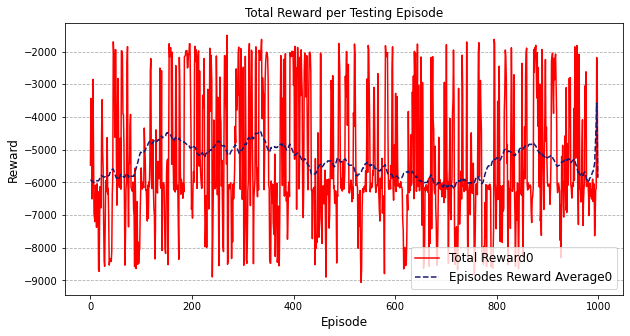

In [35]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [25]:
np.mean(rewards_0)+np.mean(rewards_1)+np.mean(rewards_2)

-8887.33046059408

In [26]:
np.mean(rewards_0+rewards_1+rewards_2)

-2962.4434868646927

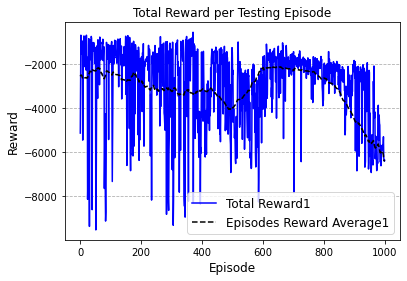

In [27]:
plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()


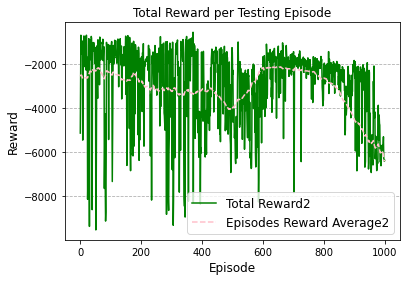

In [28]:
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

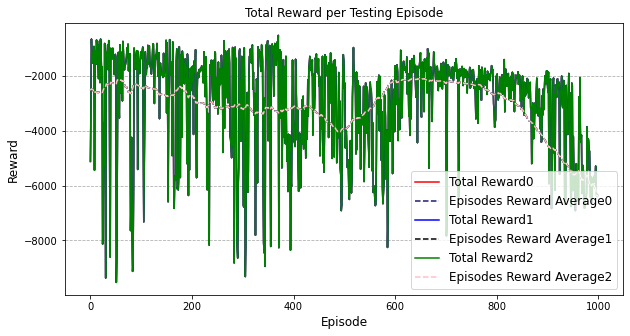

In [29]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')

plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [30]:
total_avg_reward=[]

In [31]:
for i in range(0,1000):
    k=np.mean(rewards_0[i]+rewards_1[i]+rewards_2[i])
    k=np.round(k,3)
    total_avg_reward.append(k)

In [32]:
avg_total=[]

In [33]:
for i in range(0,1000):
    k=np.mean(total_avg_reward[i:i+100])
    k=np.round(k,3)
    avg_total.append(k)

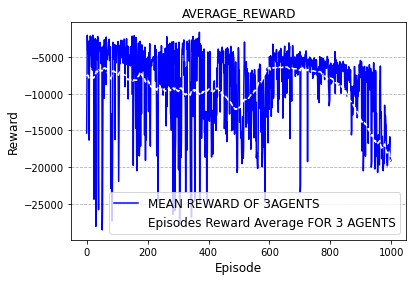

In [34]:
plt.plot(no_episodes,total_avg_reward, color = 'blue',  linestyle = '-', 
        label = 'MEAN REWARD OF 3AGENTS')
plt.plot(no_episodes, avg_total, color = 'white',  linestyle = '--', 
        label = 'Episodes Reward Average FOR 3 AGENTS')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('AVERAGE_REWARD',fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [36]:
agent1.actor.save('actor_model.h5')

In [37]:
agent1.critic.save('critic_model.h5')

[<tf.Variable 'dense_6/kernel:0' shape=(21, 16) dtype=float32, numpy=
 array([[-5.09392142e-01,  3.68164897e-01, -3.83832306e-01,
         -9.02906477e-01, -8.71102452e-01, -9.32410061e-01,
         -6.97699562e-02, -1.79780889e+00, -3.88581567e-02,
          6.25839084e-02, -6.39559189e-03, -7.76263356e-01,
         -6.19652450e-01,  4.70268488e-01, -7.15224743e-01,
         -3.10086697e-01],
        [ 6.82862937e-01, -1.14630064e-04, -1.70903906e-01,
         -1.26941785e-01, -1.27869654e+00, -4.06113058e-01,
          2.57350177e-01, -2.36584079e-02,  1.93885922e-01,
         -1.15936112e+00,  2.42937997e-01, -1.42428017e+00,
         -1.18750162e-01, -1.00830650e+00,  9.20019746e-02,
          7.40710020e-01],
        [ 6.74674332e-01,  3.74028385e-01, -2.35173032e-01,
          1.87499393e-02, -3.99986058e-01, -6.18925869e-01,
         -1.74790487e-01, -8.29222202e-02, -1.48670375e-01,
         -1.78368613e-01,  4.87543404e-01, -5.83423115e-02,
          3.06232721e-01, -2.4169232